In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


In [2]:
# Feature definitions
features = ["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage",
            "Guest_Popularity_percentage", "Episode_Sentiment", "Publication_Day",
            "Publication_Time", "Genre", "Podcast_Name"]

features_to_encode = ["Episode_Sentiment", "Publication_Day", "Publication_Time", "Genre", "Podcast_Name"]

# Label encoders
encoders = {feature: LabelEncoder() for feature in features_to_encode}


In [3]:
def preprocess(df, is_train=True):
    df["Episode_Title"] = df["Episode_Title"].str[8:]

    # Impute missing values
    for col in ["Episode_Length_minutes", "Guest_Popularity_percentage", "Number_of_Ads"]:
        df[[col]] = SimpleImputer(strategy="median").fit_transform(df[[col]])

    # Weekend flag

    # Label encode categorical variables
    for feature in features_to_encode:
        if is_train:
            df[feature] = encoders[feature].fit_transform(df[feature])
        else:
            df[feature] = encoders[feature].transform(df[feature])

    # Feature engineering
    df["Ads_Per_Minute"] = df["Number_of_Ads"] / df["Episode_Length_minutes"]
    df["People_Popularity"] = df["Host_Popularity_percentage"] + df["Guest_Popularity_percentage"]
    df["Linear"] = df["Episode_Length_minutes"] * 0.72

    return df


In [4]:
engineered = ["Ads_Per_Minute", "People_Popularity", "Linear"]
def get_train_data(file):
    df = pd.read_csv(file)
    y = df[["Listening_Time_minutes"]].to_numpy().astype(np.float32)
    df = preprocess(df, is_train=True)
    x = df[features + engineered].to_numpy().astype(np.float32)
    return x, y

def get_test_data(file):
    df = pd.read_csv(file)
    df = preprocess(df, is_train=False)
    x = df[features + engineered].to_numpy().astype(np.float32)
    return x



In [5]:
x, y = get_train_data("train.csv")
X_test = get_test_data("test.csv")


In [6]:
common_params = {
    "objective": "regression",
    "n_estimators": 1000,
    "learning_rate": 0.03,
    "max_bin": 1024,
    "num_leaves": 1024,
    "max_depth": -1,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "random_state": 42
}


In [ ]:
# single model
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y)


model = lgb.LGBMRegressor(**common_params)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric="rmse", callbacks=[lgb.log_evaluation(100)])

models = [model]

In [8]:
# LGBM ensemble 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, val_index in kf.split(x):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = lgb.LGBMRegressor(**common_params)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric="rmse", callbacks=[lgb.log_evaluation(100)])
    models.append(model)


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6221
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 12
[LightGBM] [Info] Start training from score 45.447808


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.0088	valid_0's l2: 169.228
[200]	valid_0's rmse: 12.8623	valid_0's l2: 165.439
[300]	valid_0's rmse: 12.8223	valid_0's l2: 164.412
[400]	valid_0's rmse: 12.7981	valid_0's l2: 163.792
[500]	valid_0's rmse: 12.7812	valid_0's l2: 163.358
[600]	valid_0's rmse: 12.7673	valid_0's l2: 163.004
[700]	valid_0's rmse: 12.7561	valid_0's l2: 162.718
[800]	valid_0's rmse: 12.7471	valid_0's l2: 162.487
[900]	valid_0's rmse: 12.7406	valid_0's l2: 162.324
[1000]	valid_0's rmse: 12.7348	valid_0's l2: 162.175


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6221
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 12
[LightGBM] [Info] Start training from score 45.421359


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.0451	valid_0's l2: 170.174
[200]	valid_0's rmse: 12.9006	valid_0's l2: 166.427
[300]	valid_0's rmse: 12.8625	valid_0's l2: 165.445
[400]	valid_0's rmse: 12.8379	valid_0's l2: 164.812
[500]	valid_0's rmse: 12.8186	valid_0's l2: 164.315
[600]	valid_0's rmse: 12.8007	valid_0's l2: 163.858
[700]	valid_0's rmse: 12.7873	valid_0's l2: 163.515
[800]	valid_0's rmse: 12.7761	valid_0's l2: 163.229
[900]	valid_0's rmse: 12.7664	valid_0's l2: 162.981
[1000]	valid_0's rmse: 12.7584	valid_0's l2: 162.777


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6222
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 12
[LightGBM] [Info] Start training from score 45.439263


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.0467	valid_0's l2: 170.216
[200]	valid_0's rmse: 12.8969	valid_0's l2: 166.331
[300]	valid_0's rmse: 12.857	valid_0's l2: 165.302
[400]	valid_0's rmse: 12.8292	valid_0's l2: 164.588
[500]	valid_0's rmse: 12.8081	valid_0's l2: 164.047
[600]	valid_0's rmse: 12.7904	valid_0's l2: 163.594
[700]	valid_0's rmse: 12.7765	valid_0's l2: 163.24
[800]	valid_0's rmse: 12.765	valid_0's l2: 162.944
[900]	valid_0's rmse: 12.7567	valid_0's l2: 162.733
[1000]	valid_0's rmse: 12.7489	valid_0's l2: 162.534


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6221
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 12
[LightGBM] [Info] Start training from score 45.453215


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.0467	valid_0's l2: 170.217
[200]	valid_0's rmse: 12.894	valid_0's l2: 166.256
[300]	valid_0's rmse: 12.8515	valid_0's l2: 165.16
[400]	valid_0's rmse: 12.8286	valid_0's l2: 164.572
[500]	valid_0's rmse: 12.8093	valid_0's l2: 164.077
[600]	valid_0's rmse: 12.7943	valid_0's l2: 163.694
[700]	valid_0's rmse: 12.7803	valid_0's l2: 163.337
[800]	valid_0's rmse: 12.7713	valid_0's l2: 163.106
[900]	valid_0's rmse: 12.7617	valid_0's l2: 162.861
[1000]	valid_0's rmse: 12.7545	valid_0's l2: 162.677


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6221
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 12
[LightGBM] [Info] Start training from score 45.425388


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 12.9975	valid_0's l2: 168.934
[200]	valid_0's rmse: 12.854	valid_0's l2: 165.225
[300]	valid_0's rmse: 12.816	valid_0's l2: 164.25
[400]	valid_0's rmse: 12.7912	valid_0's l2: 163.615
[500]	valid_0's rmse: 12.7707	valid_0's l2: 163.091
[600]	valid_0's rmse: 12.7559	valid_0's l2: 162.712
[700]	valid_0's rmse: 12.7443	valid_0's l2: 162.418
[800]	valid_0's rmse: 12.7355	valid_0's l2: 162.194
[900]	valid_0's rmse: 12.7266	valid_0's l2: 161.966
[1000]	valid_0's rmse: 12.7195	valid_0's l2: 161.786


In [9]:
preds = sum(model.predict(X_test) for model in models) / len(models)

with open("submission_lgbm.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "prediction"])
    for i, pred in enumerate(preds, start=750000):
        writer.writerow([i, pred])


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [21]:
features_to_plot = ["Episode_Length_minutes", "Host_Popularity_percentage", 
                    "Guest_Popularity_percentage", "Listening_Time_minutes", "Number_of_Ads"]
df = pd.read_csv("train.csv")

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

TypeError: 'module' object is not callable

In [ ]:
correlation_matrix = df[features_to_plot].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

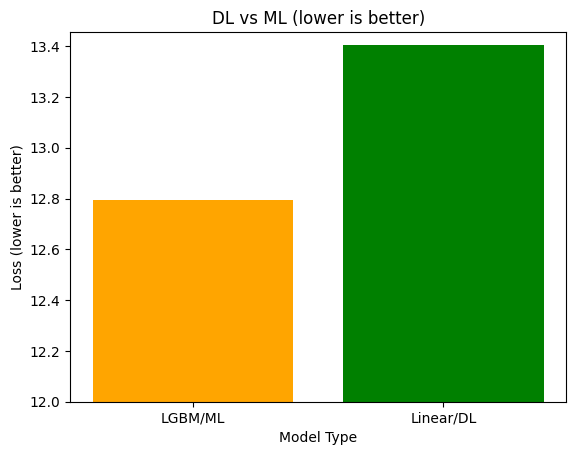

In [12]:
categories = ["LGBM/ML", "Linear/DL"]
values = [12.79389, 13.40522]

plt.bar(categories, values, color=["orange", "green"])

plt.ylim(12, max(values) + 0.05)

plt.xlabel("Model Type")
plt.ylabel("Loss (lower is better)")
plt.title("DL vs ML (lower is better)")

plt.show()

Slope: 0.7152365802402607


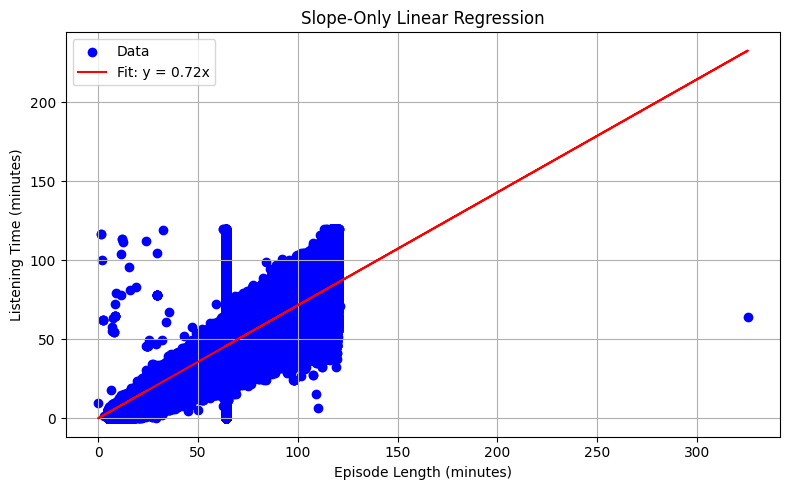

In [ ]:

# Load the CSV
df = pd.read_csv("train.csv")

# Extract variables
df["Episode_Length_minutes"] = SimpleImputer(strategy="median").fit_transform(df[["Episode_Length_minutes"]])
X = df[['Episode_Length_minutes']]  # needs to be 2D
y = df['Listening_Time_minutes']

# Fit linear regression through the origin (no intercept)
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Get slope
slope = model.coef_[0]
print(f"Slope: {slope}")

# Predict values
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred, color='red', label=f'Fit: y = {slope:.2f}x')
plt.xlabel("Episode Length (minutes)")
plt.ylabel("Listening Time (minutes)")
plt.title("Slope-Only Linear Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


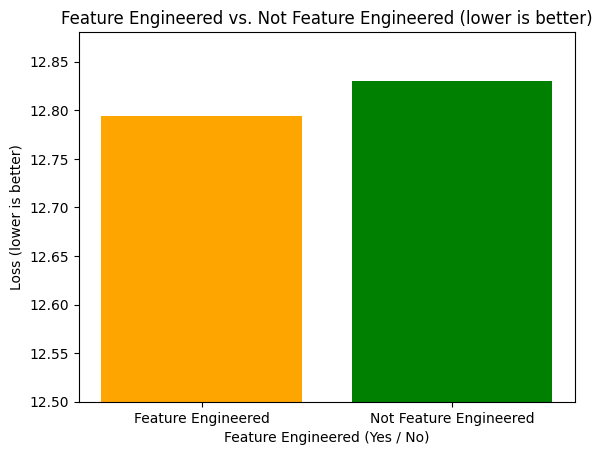

In [37]:
categories = ["Feature Engineered", "Not Feature Engineered"]
values = [12.79389, 12.83051]

plt.bar(categories, values, color=["orange", "green"])

plt.ylim(12.5, max(values) + 0.05)

plt.xlabel("Feature Engineered (Yes / No)")
plt.ylabel("Loss (lower is better)")
plt.title("Feature Engineered vs. Not Feature Engineered (lower is better)")

plt.show()

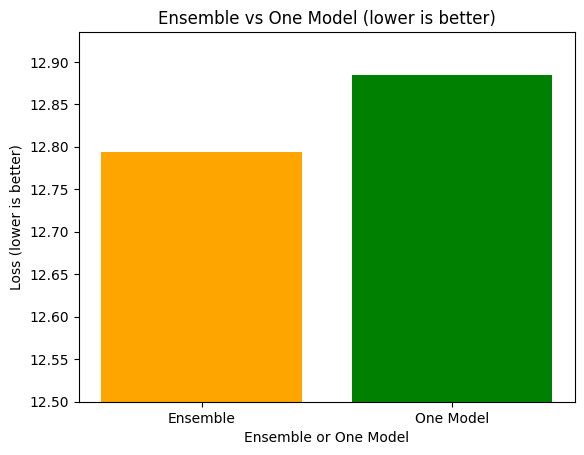

In [35]:
categories = ["Ensemble", "One Model"]
values = [12.79389, 12.88491]

plt.bar(categories, values, color=["orange", "green"])

plt.ylim(12.5, max(values) + 0.05)

plt.xlabel("Ensemble or One Model")
plt.ylabel("Loss (lower is better)")
plt.title("Ensemble vs One Model (lower is better)")

plt.show()

In [ ]:
# Create a DataFrame for the predictions and test data
prediction_df = pd.DataFrame(X_test, columns=features)
prediction_df['prediction'] = preds

# Calculate the sum of host and guest popularity
prediction_df['Popularity_Sum'] = prediction_df['Host_Popularity_percentage'] + prediction_df['Guest_Popularity_percentage']

# Assuming 'prediction_df' from your previous code contains the predictions and features
# Calculate the percentage of episode length
prediction_df['Listening_Percentage'] = (prediction_df['prediction'] / prediction_df['Episode_Length_minutes']) * 100

# Plot predicted listening time vs. sum of popularity with percentage on y-axis
plt.figure(figsize=(10, 6))
sns.kdeplot(x=prediction_df['Popularity_Sum'],
            y=prediction_df['Listening_Percentage'],  # Use the percentage column
            cmap="viridis",
            fill=True,
            cbar=True)

plt.xlabel('Sum of Host and Guest Popularity')
plt.ylabel('Percentage of Episode Length Listened')  # Update y-axis label
plt.title('Percentage of Episode Length Listened vs. Popularity Sum with Density')
plt.ylim(0, 100)  # Set y-axis limits to 0-100%
plt.grid(True)
plt.show()

# Plot predicted listening time vs. number of ads
plt.figure(figsize=(10, 6))
plt.scatter(prediction_df['Number_of_Ads'], prediction_df['prediction'], s=10, alpha=0.5)

plt.xlabel('Number of Ads')
plt.ylabel('Predicted Listening Time (minutes)')
plt.title('Predicted Listening Time vs. Number of Ads')
plt.xlim(-1, 15)  # Restrict x-axis to a maximum of 100
plt.ylim(0)  # Restrict y-axis to a minimum of 0
plt.grid(True)
plt.show()

In [ ]:
# failed linear
class PodcastPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024,  2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.net(x)